# Features for DTW

## Import libraries

In [152]:
# Import module
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib import image

from xml.dom import minidom
import re
from scipy import ndimage
import os

from skimage.filters import threshold_sauvola, threshold_otsu
from skimage.transform import resize

from PIL import Image, ImageDraw

# Path to temporary dataset --> Mnist one
mnist_train = "./../../dataset/csv/mnist_train.csv"

ImportError: cannot import name 'difference_of_gaussians' from 'skimage.filters' (/Users/nanaeaubry/opt/anaconda3/lib/python3.7/site-packages/skimage/filters/__init__.py)

In [146]:
def masking(number):
    dataset = os.path.join('..', 'dataset')
    img_fold = os.path.join(dataset, 'images')
    doc_fold = os.path.join(dataset, 'ground-truth', 'locations')
    
    img = image.imread(os.path.join(img_fold, '%d.jpg' % number))
    nr, nc = img.shape
    ygrid, xgrid = np.mgrid[:nr, :nc]
    xypix = np.vstack((xgrid.ravel(), ygrid.ravel())).T

    doc = minidom.parse(os.path.join(doc_fold, '%d.svg' % number))

    firstPaths = doc.getElementsByTagName('path')[0]
    
    _d = firstPaths.getAttribute('d')
    _d = re.sub('[MLSZ]', '', _d)
    d = np.fromstring(_d, dtype=float, sep=' ')
    cell = np.reshape(d, (int(len(d)/2), 2))

    pth = Path(cell, closed=False)

    xc = cell[:, 0]
    yc = cell[:, 1]

    mask = pth.contains_points(xypix, radius=0.1)

    mask = mask.reshape(img.shape)

    masked = np.ma.masked_array(img, ~mask)

    masked = masked.filled(255)

    xmin, xmax = int(xc.min()), int(np.ceil(xc.max()))
    ymin, ymax = int(yc.min()), int(np.ceil(yc.max()))

    trimmed = masked[ymin:ymax, xmin:xmax]
    print(trimmed.shape)

    return trimmed


(90, 188)


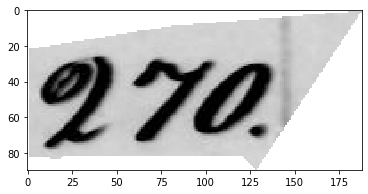

In [147]:
trimmedimg = masking(270)
plt.imshow(trimmedimg, cmap=plt.cm.gray)
plt.show()

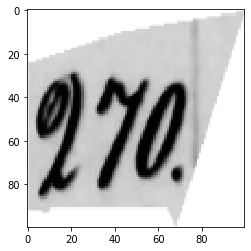

In [148]:
resizedimg = resize(trimmedimg, (100, 100))
plt.imshow(resizedimg, cmap=plt.cm.gray)
plt.show()

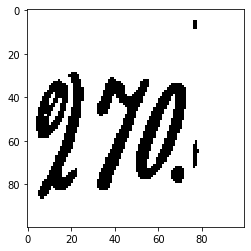

In [149]:
thresh_sauvola = threshold_sauvola(resizedimg, window_size=15)
sauvolaimg = resizedimg > thresh_sauvola
plt.imshow(sauvolaimg, cmap=plt.cm.gray)
plt.show()

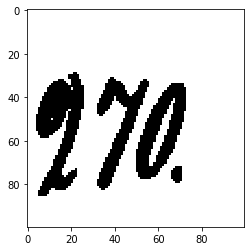

In [150]:
otsuimg = resizedimg > threshold_otsu(resizedimg)
plt.imshow(otsuimg, cmap=plt.cm.gray)
plt.show()

In [151]:
# diffgaussimg = resizedimg > difference_of_gaussians(resizedimg, 1.5)
# plt.imshow(diffgaussimg, cmap=plt.cm.gray)
# plt.show()

NameError: name 'difference_of_gaussians' is not defined

## Load data

In [33]:
def show_image(x):
    plt.imshow(x, interpolation='nearest', cmap='gray')
    plt.show()
    

def read_data(filename):
    df = pd.read_csv(filename, header=None)
    #data into numpy array
    data = df.iloc[:, 1:].values.reshape(-1, 1, 28, 28) /255.0  
    labels = df.iloc[:, 0].values
    
#     Temporary binarization with threshold of 0.5 since pixel value in between 0 and 1.
    threshold = 0.5
    data = np.where(data > threshold, 1, 0)
    
    return data, labels


# Load the training and the test set
train_data, train_labels = read_data(mnist_train)

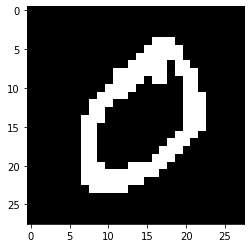

In [34]:
# Selection of an image of the dataset to work with.
img = train_data[1][0]
m, n = np.shape(img)

# Plot of the image
show_image(img)

In [42]:
imgcroped = crop(img, [5, 0, 0, 0])
show_image(imgcroped)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (4,) and requested shape (2,2)

## Features functions

In [6]:
# Returns the index of the pixel composing the lower contour of the shape.
def lowerContour(feature_vector):
#     If there is no black pixels
    if np.size(np.where(feature_vector == 1)) == 0:
        lc = None
    else:
        lc = np.max(np.where(feature_vector == 1))
    return lc

# Returns the index of the pixel composing the upper contour of the shape.
def upperContour(feature_vector):
#     If there is no black pixels
    if np.size(np.where(feature_vector == 1)) == 0:
        uc = None
    else:
        uc = np.min(np.where(feature_vector == 1))
    return uc

# -----
# TODO 
# -----
# Number of black and white transitions


# Returns the fraction of blach pixels in the feature vector.
def fracBlackPx(feature_vector):
    nb_bp = (feature_vector == 1).sum()
    fraction = nb_bp/np.size(feature_vector)
    return fraction

# Returns the fraction of blach pixels between the lower and upper contour of the feature vector.
def fracBetweenLcUc(feature_vector, lc, uc):
#     If there is no black pixels    
    if lc == None or uc == None:
        frac = None
    else:
        between = feature_vector[uc:lc+1] # +1 to put in the black pixel of the lower contour
        frac = fracBlackPx(between)
        
    return frac

# -----
# TODO
# -----
# Gradient: difference LC[i] , UC[i] to LC[i+1] , UC[i+1]

In [5]:
# each column of the image is a feature vector (1 px wide)
for i in range(m):
    fv = img[:,i]
    print(f"feature vector {i}: {fv}")
    
    lc = lowerContour(fv)
    print(f"lower contour: {lc}")
    
    uc = upperContour(fv)
    print(f"upper contour: {uc}")
    
    frac = fracBlackPx(fv)
    print(f"fraction: {frac}")
    
    frac_lc_uc = fracBetweenLcUc(fv, lc, uc)
    print(f"fraction between lc and uc: {frac_lc_uc}")
    
    print("\n")

feature vector 0: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
lower contour: None
upper contour: None
fraction: 0.0
fraction between lc and uc: None


feature vector 1: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
lower contour: None
upper contour: None
fraction: 0.0
fraction between lc and uc: None


feature vector 2: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
lower contour: None
upper contour: None
fraction: 0.0
fraction between lc and uc: None


feature vector 3: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
lower contour: None
upper contour: None
fraction: 0.0
fraction between lc and uc: None


feature vector 4: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
lower contour: None
upper contour: None
fraction: 0.0
fraction between lc and uc: None


feature vector 5: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
lower contour: None
upper contour: None
fraction: 0.0
fraction between lc and uc: None


feature ve

# Test to look at and binarize the cropped word-images

In [6]:
# import cropping

# crop = cropping.masking(270)

In [7]:
# # Temporary threshold value.
# t = 0.4

# # First word-image of the file 207 with pixel values between 0 and 1.
# a = crop["270-01-01"]/255
# show_image(a)
# # Temporary binarization
# a_bin = np.where(a > t, 1, 0)
# show_image(a_bin)

# b = crop["270-01-05"]/255
# show_image(b)
# b_bin = np.where(b > t, 1, 0)
# show_image(b_bin)

# c = crop["270-01-06"]/255
# show_image(c)
# c_bin = np.where(c > t, 1, 0)
# show_image(c_bin)